# Info

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from analysis.datasets import load_entsoe
from analysis.splits_old import to_train_validation_test_data
from tabpfn import TabPFNRegressor
from analysis.transformations_old import add_interval_index, add_lagged_features, scale_power_data
from torchinfo import summary
from analysis.TabPFN_copy import compute_crps_nll_9_quantiles
import torch
import seaborn as sns
from analysis.TabPFN_copy import fit_tail_distribution, plot_cdf_pdf_dynamic, plot_pdf_from_logits, plot_pdf_smoothed_with_moving_average
from analysis.scores import compute_nll_smoothed_5000_logits
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML

mode = "train"  # Replace this with the actual value of 'mode'

html_content = f"""
<h1 style="color:red; font-size: 60px">-------------------------------------</h1>
<h1 style="color:red; font-size: 60px">Current mode: {mode}</h1>
<h1 style="color:red; font-size: 60px">-------------------------------------</h1>
"""

display(HTML(html_content))


# Train and fit TabPFN

## Function to compute crps from 5000 logits and 5001 borders

## Preprocessing

In [3]:
if mode == "train":

    feature_columns = ['ws_10m_loc_mean', 'ws_100m_loc_mean', 'power_t-96']
    target_column='power'

    entsoe = load_entsoe()
    entsoe = scale_power_data(entsoe)
    entsoe = add_lagged_features(entsoe)
    entsoe = add_interval_index(entsoe)
    entsoe.dropna(inplace=True)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)


In [4]:
entsoe

,power,ws_10m_loc_1,ws_10m_loc_10,ws_10m_loc_2,ws_10m_loc_3,ws_10m_loc_4,ws_10m_loc_5,ws_10m_loc_6,ws_10m_loc_7,ws_10m_loc_8,...,ws_100m_loc_3,ws_100m_loc_4,ws_100m_loc_5,ws_100m_loc_6,ws_100m_loc_7,ws_100m_loc_8,ws_100m_loc_9,ws_100m_loc_mean,power_t-96,interval_index
time,,,,,,,,,,,,,,,,,,,,,
2016-01-02 00:00:00,-3.324236,2.7200,1.68,2.6400,3.1400,3.1100,3.210,3.1100,2.6300,2.6500,...,5.3900,5.200,5.8700,5.650,4.87,4.5200,5.32,5.190,-2.465104,1
2016-01-02 00:15:00,-3.238179,2.7975,1.74,2.6625,3.1325,3.1850,3.235,3.1100,2.6500,2.7025,...,5.4000,5.315,5.8825,5.645,4.81,4.6400,5.33,5.160,-2.499602,2
2016-01-02 00:30:00,-3.171487,2.8750,1.80,2.6850,3.1250,3.2600,3.260,3.1100,2.6700,2.7550,...,5.4100,5.430,5.8950,5.640,4.75,4.7600,5.34,5.130,-2.485377,3
2016-01-02 00:45:00,-3.118232,2.9525,1.86,2.7075,3.1175,3.3350,3.285,3.1100,2.6900,2.8075,...,5.4200,5.545,5.9075,5.635,4.69,4.8800,5.35,5.100,-2.451358,4
2016-01-02 01:00:00,-3.114251,3.0300,1.92,2.7300,3.1100,3.4100,3.310,3.1100,2.7100,2.8600,...,5.4300,5.660,5.9200,5.630,4.63,5.0000,5.36,5.070,-2.405335,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,-0.288074,6.7200,5.26,5.9600,7.0700,6.0500,6.660,6.6500,6.0400,7.1500,...,11.7500,10.610,11.1700,11.120,10.32,11.5700,11.05,9.940,-0.659371,89
2024-12-31 22:15:00,-0.266036,6.7725,5.36,6.0350,7.0800,6.0825,6.665,6.6575,6.0325,7.1225,...,11.6925,10.630,11.1050,11.115,10.35,11.5975,11.17,9.945,-0.671155,90
2024-12-31 22:30:00,-0.245825,6.8250,5.46,6.1100,7.0900,6.1150,6.670,6.6650,6.0250,7.0950,...,11.6350,10.650,11.0400,11.110,10.38,11.6250,11.29,9.950,-0.672883,91


## Splits

In [4]:
if mode == "train":
    train_start = "2016-01-01"
    train_end = "2022-12-31 23:45:00"
    validation_start = "2023-01-01"
    validation_end = "2023-12-31 23:45:00"

    train, validation, test = to_train_validation_test_data(entsoe, train_end, validation_end)
    X_train, y_train = train[feature_columns], train[target_column]
    X_validation, y_validation = validation[feature_columns], validation[target_column]

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

# of training observations: 245376 | 77.76%
# of validation observations: 35040 | 11.10%
# of test observations: 35133 | 11.13%


## Train 4 models for each quarter

### Parameters

In [5]:
filepath1 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_first_q"
filepath2 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_second_q"
filepath3 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_third_q"
filepath4 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_fourth_q"
filepath5 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_meta_info"
filepath6 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_overall"
filepath7 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_first_q"
filepath8 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_second_q"
filepath9 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_third_q"
filepath10 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_fourth_q"

if mode == "train":

    device = 'auto'
    fit_mode='low_memory'
    random_state=42
    ignore_pretaining_limits = False



In [6]:
if mode == "train":

    # Define the train-validation splits
    splits = {
        "first_q": {
            "train": ("2022-01-01", "2022-03-31"),
            "validation": ("2023-01-01", "2023-03-31"),
            #"train": ("2022-01-01", "2022-01-03"),
            #"validation": ("2023-01-01", "2023-01-03"),
        },
        #"second_q": {
        #    "train": ("2022-04-01", "2022-06-30"),
        #    "validation": ("2023-04-01", "2023-06-30"),
            #"train": ("2022-01-04", "2022-01-06"),
            #"validation": ("2023-01-04", "2023-01-06"),
        #},
        #"third_q": {
        #    "train": ("2022-07-01", "2022-09-30"),
        #    "validation": ("2023-07-01", "2023-09-30"),
        #},
        #"fourth_q": {
        #    "train": ("2022-10-01", "2022-12-31"),
        #    "validation": ("2023-10-01", "2023-12-31"),
            #"train": ("2022-10-01", "2022-10-07"),
            #"validation": ("2023-12-26", "2023-12-31")
        #}
    }
    # Initialize dictionary to store results
    results_dict = {}
    summary_stats_overall = {}

    # Loop through each quarter
    for quarter, dates in splits.items():
        print(f"Processing {quarter}...")

        # Extract train data
        X_train_q = X_train.loc[dates["train"][0]:dates["train"][1]]
        y_train_q = y_train.loc[dates["train"][0]:dates["train"][1]]
        
        # Extract validation data
        X_validation_q = X_validation.loc[dates["validation"][0]:dates["validation"][1]]
        y_validation_q = y_validation.loc[dates["validation"][0]:dates["validation"][1]]

        # Train model
        model = TabPFNRegressor(device=device, fit_mode=fit_mode, random_state=random_state)
        model.fit(X_train_q, y_train_q)

        # Define quantiles
        quantiles_custom = np.arange(0.1, 1, 0.1)
        probabilities_q = quantiles_custom

        # Predict
        probs_val_q = model.predict(X_validation_q, output_type="full", quantiles=quantiles_custom)

        # 5000 logits
        logits_q = probs_val_q["logits"]

        # 5001 borders
        borders_q = probs_val_q["criterion"].borders

        # 9 quantiles
        all_quantiles_q = np.array(probs_val_q["quantiles"])

        # Convert y_validation to tensor
        y_validation_q_torch = torch.tensor(y_validation_q.values, dtype=torch.float32)


        # 1. Compute NLL smoothed with moving average of pdf of neighboring bins
        nll_smoothed = compute_nll_smoothed(logits=logits_q, borders=borders_q, y_values=y_validation_q_torch, window_size=9)

        # 2. Compute CRPS and NLL using the 5000 logits and 5001 borders from TabPFN
        crps_values_torch_q = compute_crps_pytorch(logits_q, borders_q, y_validation_q_torch)
        #print(f"CRPS shape for {quarter}:", crps_values_torch_q.shape)


        # 3. Compute NLL using inbuild function in TabPFN
        nll_torch_q = probs_val_q["criterion"].forward(logits_q, y_validation_q_torch)
        finite_nlls = nll_torch_q[torch.isfinite(nll_torch_q)] # Find the max ignoring inf and NaN
        max_nll_so_far = float('-9999') # Initialize max_nll_so_far to a very small number
        if finite_nlls.numel() > 0:  # numel() = number of elements in finite_nlls
            max_nll_so_far = max(max_nll_so_far, finite_nlls.max().item())
            #print(f"Updated max_nll_so_far to: {max_nll_so_far} based on the current finite NLLs")
        infinite_indices = torch.nonzero(~torch.isfinite(nll_torch_q)).squeeze() # Find the indices of the infinite values
        infinite_values = nll_torch_q[infinite_indices] # Replace infinite values with max_nll_so_far
        nll_torch_q[~torch.isfinite(nll_torch_q)] = max_nll_so_far
        #print(f"Replaced infinite values at indices {infinite_indices.tolist()} in nll_torch_q with the value {max_nll_so_far}.")


        # 4. Compute CRPS and NLL of 9 quantiles using 3 interpolation methods: Linear, Hybrid, normal 
        yt = entsoe["power"]
        quantile_10 = np.percentile(yt, probabilities_q * 100)
        mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities_q[:2]) # Fit tails
        mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities_q[-2:])
        crps_cdf_linear_a_full_q = []
        crps_hybrid_cdf_a_full_q = []
        crps_normal_a_full_q = []
        nll_pdf_linear_a_full_q = []
        nll_pdf_hybrid_a_full_q = []
        nll_normal_a_full_q = []

        for i in range(y_validation_q.shape[0]): # Iterate through validation samples
            quantile_i = all_quantiles_q[:, i]
            y_i = y_validation_q.iloc[i]
            crps_linear, crps_hybrid, crps_normal, nll_linear, nll_hybrid, nll_normal = compute_crps_nll_9_quantiles(
                quantile_i, probabilities_q, y_i, -20, 5, mu_left_asym, sigma_left_asym, mu_right_asym, sigma_right_asym
            )
            crps_cdf_linear_a_full_q.append(crps_linear)
            crps_hybrid_cdf_a_full_q.append(crps_hybrid)
            crps_normal_a_full_q.append(crps_normal)
            nll_pdf_linear_a_full_q.append(nll_linear)
            nll_pdf_hybrid_a_full_q.append(nll_hybrid)
            nll_normal_a_full_q.append(nll_normal)

        mean_crps_cdf_linear_q = np.mean(crps_cdf_linear_a_full_q)
        mean_crps_hybrid_cdf_q = np.mean(crps_hybrid_cdf_a_full_q)
        mean_crps_normal_q = np.mean(crps_normal_a_full_q)
        mean_nll_pdf_linear_q = np.mean(nll_pdf_linear_a_full_q)
        mean_nll_pdf_hybrid_q = np.mean(nll_pdf_hybrid_a_full_q)
        mean_nll_normal_q = np.mean(nll_normal_a_full_q)
        mean_nll_smoothed = np.mean(nll_smoothed)
        print(f"Mean CRPS for {quarter} - CDF Linear: {mean_crps_cdf_linear_q:.4f}")
        print(f"Mean CRPS for {quarter} - Hybrid CDF: {mean_crps_hybrid_cdf_q:.4f}")
        print(f"Mean CRPS for {quarter} - Normal: {mean_crps_normal_q:.4f}")
        print(f"Mean NLL for {quarter} - PDF Linear: {mean_nll_pdf_linear_q:.4f}")
        print(f"Mean NLL for {quarter} - PDF Hybrid: {mean_nll_pdf_hybrid_q:.4f}")
        print(f"Mean NLL for {quarter} - Normal: {mean_nll_normal_q:.4f}")


        # Result 1. CRPS, NLL, y values, logits
        logits_df = pd.DataFrame(logits_q.cpu().numpy())
        logits_df.columns = [f"Logit_{i+1}" for i in range(logits_df.shape[1])] # Rename columns for clarity

        result_q = { # Store CRPS, NLL, y values separately
            'CRPS Linear': crps_cdf_linear_a_full_q,
            'CRPS Hybrid': crps_hybrid_cdf_a_full_q,
            'CRPS Normal': crps_normal_a_full_q,
            'CRPS (5000 quantiles)': crps_values_torch_q,
            'NLL Linear': nll_pdf_linear_a_full_q,
            'NLL Hybrid': nll_pdf_hybrid_a_full_q,
            'NLL Normal': nll_normal_a_full_q,
            'NLL (5000 quantiles)': nll_torch_q,
            'NLL smoothed (moving average)': nll_smoothed,
            'y values': y_validation_q_torch,
        }

        summary_stats_q = {
            'CRPS Linear': [mean_crps_cdf_linear_q, np.min(crps_cdf_linear_a_full_q), np.max(crps_cdf_linear_a_full_q), np.median(crps_cdf_linear_a_full_q)],
            'CRPS Hybrid': [mean_crps_hybrid_cdf_q, np.min(crps_hybrid_cdf_a_full_q), np.max(crps_hybrid_cdf_a_full_q), np.median(crps_hybrid_cdf_a_full_q)],
            'CRPS Normal': [mean_crps_normal_q, np.min(crps_normal_a_full_q), np.max(crps_normal_a_full_q), np.median(crps_normal_a_full_q)],
            'CRPS (5000 quantiles)': [crps_values_torch_q.mean().item(), np.min(crps_values_torch_q.cpu().numpy()), np.max(crps_values_torch_q.cpu().numpy()), np.median(crps_values_torch_q.cpu().numpy())],
            'NLL Linear': [mean_nll_pdf_linear_q, np.min(nll_pdf_linear_a_full_q), np.max(nll_pdf_linear_a_full_q), np.median(nll_pdf_linear_a_full_q)],
            'NLL Hybrid': [mean_nll_pdf_hybrid_q, np.min(nll_pdf_hybrid_a_full_q), np.max(nll_pdf_hybrid_a_full_q), np.median(nll_pdf_hybrid_a_full_q)],
            'NLL Normal': [mean_nll_normal_q, np.min(nll_normal_a_full_q), np.max(nll_normal_a_full_q), np.median(nll_normal_a_full_q)],
            'NLL (5000 quantiles)': [nll_torch_q.mean().item(), np.min(nll_torch_q.cpu().numpy()), np.max(nll_torch_q.cpu().numpy()), np.median(nll_torch_q.cpu().numpy())],
            'NLL smoothed (moving average)': [mean_nll_smoothed, np.min(mean_nll_smoothed), np.max(nll_smoothed), np.median(nll_smoothed)]
        }

        results_q = pd.DataFrame(result_q).round(8)
        results_q_with_logits = pd.concat([results_q, logits_df], axis=1) # Merge logits dataframe with CRPS, NLL, y values dataframe

        # Result 2. borders
        borders_df = pd.DataFrame(borders_q.cpu().numpy(), columns=["Borders"])

        summary_stats_q_pd = pd.DataFrame(summary_stats_q, index=['Mean', 'Min', 'Max', 'Median'])

        results_dict[quarter] = {
            "results": results_q_with_logits,  # Store per-entry results
            "borders": borders_df,  # Store borders as a separate DataFrame
            "summary": summary_stats_q_pd  # Store summary stats for this quarter
        }

        # Result 3. Summary stats within a quarter
        print("summary stats of Quarter")
        display(summary_stats_q_pd)

        summary_stats_overall[quarter] = summary_stats_q_pd

        # Print summary
        #print("✅ Processing complete. Results stored in `results_dict`.")

    # Result 4. Summary stats across the 4 quarters
    all_quarters_df = pd.concat([results_dict[quarter]["results"] for quarter in results_dict], ignore_index=True)
    summary_stats = all_quarters_df.describe().loc[['mean', 'min', '50%', 'max']].rename(index={'50%': 'median'})

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

Processing first_q...


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

KeyboardInterrupt: 

## Create meta table

In [8]:
if mode == "train":
    
    epsilon = 1e-3
    lag=96
    transformation = "log(power / max power value + epsilon)"

    # Table for metadata

    split_rows = []
    
    for quarter, dates in splits.items():
        # Create a row with both 'train' and 'validation' in the same row
        split_rows.append({
            'quarter': quarter,
            'train_start_date': dates['train'][0],
            'train_end_date': dates['train'][1],
            'validation_start_date': dates['validation'][0],
            'validation_end_date': dates['validation'][1],
            'random_seed': random_state,
            'num_splits': 4,
            'epsilon': epsilon,
            'lag': lag,
            'transformation': transformation,
            'features': feature_columns,
            'model_type': "TabPFNRegressor",
            'device': "auto",
            'fit_mode': fit_mode,
            "ignore_pretaining_limits": ignore_pretaining_limits
        })

    meta_info_df = pd.DataFrame(split_rows)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")


Skipping this cell, required mode: train, but current mode is: load


# Write trained output from TabPFN to files

## Saving each quarter to file

In [9]:
import pickle


if mode == "train":
    with open(filepath1, "wb") as file:
        pickle.dump(results_dict["first_q"], file) #stores the DataFrames "results", "borders", "summary" 

    with open(filepath2, "wb") as file:
        pickle.dump(results_dict["second_q"], file) #stores the DataFrames "results", "borders", "summary" 

    with open(filepath3, "wb") as file:
        pickle.dump(results_dict["third_q"], file) #stores the DataFrames "results", "borders", "summary" 

    with open(filepath4, "wb") as file:
        pickle.dump(results_dict["fourth_q"], file) #stores the DataFrames "results", "borders", "summary" 

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

Skipping this cell, required mode: train, but current mode is: load


In [10]:
if mode == "train":
    with open(filepath7, "wb") as file:
        pickle.dump(results_dict["first_q"]["summary"], file)

    with open(filepath8, "wb") as file:
        pickle.dump(results_dict["second_q"]["summary"], file)

    with open(filepath9, "wb") as file:
        pickle.dump(results_dict["third_q"]["summary"], file)

    with open(filepath10, "wb") as file:
        pickle.dump(results_dict["fourth_q"]["summary"], file)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

Skipping this cell, required mode: train, but current mode is: load


## Saving meta data to file

In [11]:
if mode == "train":
    with open(filepath5, "wb") as file:
        pickle.dump(meta_info_df, file)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

Skipping this cell, required mode: train, but current mode is: load


## Temp: created by loading in the results of quarters not directly from TabPFN

# Save summary stats

In [12]:
if mode == "train":
    with open(filepath6, "wb") as file:
        pickle.dump(summary_stats, file)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

Skipping this cell, required mode: train, but current mode is: load


# Load trained output

In [13]:
if mode == "load":

    with open(filepath1, "rb") as file:
        first_q = pickle.load(file)
        print("q1")
        display(first_q["results"].head())
        display(first_q["borders"].head())
        display(first_q["summary"])
        print("-------------------")
    with open(filepath2, "rb") as file:
        second_q = pickle.load(file)
        print("q2")
        display(second_q["results"].head())
        display(second_q["borders"].head())
        display(second_q["summary"])
        print("-------------------")
    with open(filepath3, "rb") as file:
        third_q = pickle.load(file)
        print("q3")
        display(third_q["results"].head())
        display(third_q["borders"].head())
        display(third_q["summary"])
        print("-------------------")
    with open(filepath4, "rb") as file:
        fourth_q = pickle.load(file)
        print("q4")
        display(fourth_q["results"].head())
        display(fourth_q["borders"].head())
        display(fourth_q["summary"])
else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

q1


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.286544,0.315913,0.196862,0.207918,-0.478470,-0.733121,0.405837,-0.590741,-0.563193,-0.539165,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.456878
1,0.358878,0.359571,0.281637,0.272509,1.303051,1.484064,3.074877,0.674396,0.313154,-0.518601,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451
2,0.270917,0.305586,0.186540,0.185323,-0.777790,-1.056299,0.276867,-1.087519,-0.866392,-0.555433,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.496099
3,0.260234,0.297001,0.166072,0.186024,0.213276,-0.058962,0.142388,-0.649525,-0.515941,-0.509552,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451
4,0.301981,0.336770,0.214784,0.217724,-0.729570,-1.058976,0.549073,-0.867136,-0.754282,-0.552363,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.881761


,Borders
0,-115.799980
1,-33.593388
2,-29.296274
3,-27.505493
4,-26.062775


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average)
Mean,0.372855,0.358841,0.315476,0.317299,2.122292,0.561304,5.410802,1.418843,1.339172
Min,0.083712,0.014705,0.004594,0.004730,-3.036598,-3.098955,-3.040974,-3.222030,1.339172
Max,2.798363,3.211003,3.230540,3.220061,5.292331,13.494987,614.972518,13.211125,11.080271
Median,0.228939,0.233852,0.147593,0.154788,2.053456,0.389291,0.464262,0.978735,0.901029


-------------------
q2


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.778766,0.747825,0.752790,0.771972,4.200909,2.248390,3.400376,5.742054,5.508258,-1.294842,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.615108
1,0.812495,0.786749,0.794609,0.812154,4.203960,2.386437,3.737921,6.002278,5.862530,-1.272126,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.652379
2,0.831389,0.802707,0.819051,0.839872,4.205388,2.222043,4.129362,6.041480,5.864461,-1.262308,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.627378
3,0.894991,0.855453,0.903020,0.877349,4.208683,2.260409,6.534159,5.747745,5.824454,-1.248273,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.555919
4,0.894454,0.856979,0.904511,0.888001,4.210377,2.286823,7.328557,5.612416,5.900092,-1.251558,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.602986


,Borders
0,-104.500603
1,-30.924780
2,-27.078815
3,-25.476046
4,-24.184797


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average)
Mean,0.379866,0.324128,0.311263,0.317698,1.989015,0.876996,2.495446,1.378433,1.344942
Min,0.083811,0.017582,0.006714,0.006488,-2.668917,-2.821884,-2.636894,-3.032201,1.344942
Max,2.364685,2.520653,2.582767,2.505795,5.275683,9.382992,393.932083,10.347389,10.387455
Median,0.289944,0.223377,0.202830,0.216490,1.337379,0.741027,0.537979,1.050125,1.005241


-------------------
q3


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.448737,0.376029,0.394415,0.379405,1.021502,0.976655,1.146273,0.692008,0.737710,-2.801715,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.026094,-15.770535
1,0.280974,0.205855,0.220722,0.209550,0.960299,1.010058,0.802226,1.340408,1.395665,-2.807546,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.620629,-14.953773
2,0.217235,0.140358,0.166351,0.140638,0.091755,0.110955,0.492770,0.572248,0.030970,-2.811452,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.026094,-15.347678
3,0.175751,0.099370,0.103953,0.096776,0.194787,0.320224,0.081194,0.281633,0.372410,-2.807546,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.587839,-14.707641
4,0.195299,0.118124,0.122014,0.121072,0.321624,0.375904,0.244986,0.325453,0.355729,-2.769300,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.864826,-14.763730


,Borders
0,-102.444839
1,-30.506809
2,-26.746456
3,-25.179363
4,-23.916857


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average)
Mean,0.428157,0.374946,0.364750,0.370263,2.219662,1.082090,3.914017,1.589213,1.548595
Min,0.083992,0.017809,0.007120,0.006888,-2.648900,-2.679531,-2.574000,-2.831817,1.548595
Max,2.476387,2.485498,2.704557,2.610613,5.262982,10.872191,1645.895998,11.481845,10.700696
Median,0.330757,0.266011,0.249273,0.259810,1.619716,0.982402,0.790983,1.301516,1.251605


-------------------
q4


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.251926,0.174959,0.187051,0.170426,0.484571,-0.815268,0.245122,0.262002,-0.918360,-2.298476,...,-inf,-inf,-inf,-14.953773,-inf,-inf,-inf,-inf,-17.616362,-14.204114
1,0.245930,0.170024,0.182793,0.171896,5.178007,-0.388919,0.220539,1.082626,1.257643,-2.324590,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.452294
2,0.293540,0.219670,0.226174,0.231432,5.181585,0.116991,0.485396,3.098203,3.315390,-2.323388,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.823153
3,0.454110,0.382441,0.404642,0.413469,5.188755,0.571732,2.480649,3.836962,3.855583,-2.309077,...,-inf,-inf,-inf,-14.744682,-inf,-inf,-inf,-inf,-inf,-14.977304
4,0.648574,0.566627,0.640750,0.644148,5.206106,1.004765,3.727454,5.466805,4.957520,-2.279903,...,-inf,-inf,-inf,-14.725990,-inf,-inf,-inf,-inf,-inf,-15.347678


,Borders
0,-95.082840
1,-28.012060
2,-24.506130
3,-23.045065
4,-21.867979


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average)
Mean,0.359825,0.333734,0.301317,0.302762,2.517218,1.218145,10.236980,1.758970,1.713749
Min,0.083667,0.011557,0.004914,0.004545,-3.068754,-3.133443,-2.955272,-3.106228,1.713749
Max,2.222664,2.295143,2.483551,2.448180,5.275931,13.841492,3217.045811,11.556959,12.999496
Median,0.270078,0.246092,0.196920,0.201727,3.992091,0.841983,0.754331,1.348241,1.281883


## Load meta data

In [14]:
if mode == "load":

    with open(filepath5, "rb") as file:
        meta_info = pickle.load(file)
        display(meta_info)

,quarter,train_start_date,train_end_date,validation_start_date,validation_end_date,random_seed,num_splits,epsilon,lag,transformation,features,model_type,device,fit_mode,ignore_pretaining_limits
0,first_q,2022-01-01,2022-03-31,2023-01-01,2023-03-31,42,4,0.001,96,log(power / max power value + epsilon),"[ws_10m_loc_mean, ws_100m_loc_mean, power_t-96]",TabPFNRegressor,auto,low_memory,False
1,second_q,2022-04-01,2022-06-30,2023-04-01,2023-06-30,42,4,0.001,96,log(power / max power value + epsilon),"[ws_10m_loc_mean, ws_100m_loc_mean, power_t-96]",TabPFNRegressor,auto,low_memory,False
2,third_q,2022-07-01,2022-09-30,2023-07-01,2023-09-30,42,4,0.001,96,log(power / max power value + epsilon),"[ws_10m_loc_mean, ws_100m_loc_mean, power_t-96]",TabPFNRegressor,auto,low_memory,False
3,fourth_q,2022-10-01,2022-12-31,2023-10-01,2023-12-31,42,4,0.001,96,log(power / max power value + epsilon),"[ws_10m_loc_mean, ws_100m_loc_mean, power_t-96]",TabPFNRegressor,auto,low_memory,False


## Load summary statistics

In [15]:
if mode == "load":

    with open(filepath6, "rb") as file:
        summary_stats_overall = pickle.load(file)
        display(summary_stats_overall)

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
mean,0.385258,0.347917,0.323276,0.327084,2.213150,0.936837,5.523149,1.537441,1.487811,-1.863000,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.605111
min,0.083667,0.011557,0.004594,0.004545,-3.068754,-3.133443,-3.040974,-3.222030,-2.995760,-6.796530,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-18.021828
median,0.281883,0.241885,0.201559,0.210546,1.796157,0.765057,0.655378,1.178272,1.132559,-1.648118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.620629
max,2.798363,3.211003,3.230540,3.220061,5.292332,13.841492,3217.045811,13.211125,12.999496,-0.018224,...,-12.698816,-12.777438,-12.488438,-12.374615,-12.766939,-12.594676,-11.258519,-11.476477,-11.112573,-8.985601


# Analysis of problematic NLL, CRPS cases (where either is high while the other is not)

In [16]:
if mode == "load":

    case = 1

    if case == 1:
        y_values_min = -4.50
        y_values_max = -4.60
        nll_min = 8
    
    elif case == 2:
        y_values_min = -2.55
        y_values_max = -2.58
        nll_min = 2.5

    else:
        y_values_min = -1.55
        y_values_max = -1.58
        nll_min = 6

    problematic_cases_q1 = first_q['results'][(first_q['results']["y values"] < y_values_min) & (first_q['results']["y values"] > y_values_max) & (first_q['results']["NLL (5000 quantiles)"] > nll_min)]
    problematic_cases_q2 = second_q['results'][(second_q['results']["y values"] < y_values_min) & (second_q['results']["y values"] > y_values_max) & (second_q['results']["NLL (5000 quantiles)"] > nll_min)]
    problematic_cases_q3 = third_q['results'][(third_q['results']["y values"] < y_values_min) & (third_q['results']["y values"] > y_values_max) & (third_q['results']["NLL (5000 quantiles)"] > nll_min)]
    problematic_cases_q4 = fourth_q['results'][(fourth_q['results']["y values"] < y_values_min) & (fourth_q['results']["y values"] > -y_values_max) & (fourth_q['results']["NLL (5000 quantiles)"] > nll_min)]

    print(f"problematic: y values < {y_values_min} and y values > {y_values_max} and NLL (5000 quantiles) > {nll_min}")
    print("q1")
    display(problematic_cases_q1)
    print("-------------------")
    print("q2")
    display(problematic_cases_q2)
    print("-------------------")
    print("q3")
    display(problematic_cases_q3)
    print("-------------------")
    print("q4")
    display(problematic_cases_q4)
    print("-------------------")

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

problematic: y values < -4.5 and y values > -4.6 and NLL (5000 quantiles) > 8
q1


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
2635,1.662549,1.832932,1.908695,1.910849,5.151008,4.004706,69.078603,8.127335,8.86039,-4.564819,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.397486


-------------------
q2


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
8554,1.580799,1.746040,1.793428,1.800071,5.145167,4.012086,28.443902,9.159767,9.205653,-4.548012,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.970042
8557,1.618476,1.790859,1.836183,1.844465,5.145254,4.073940,26.003303,9.368197,9.339598,-4.587677,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.766214


-------------------
q3


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
8191,1.561881,1.732153,1.787206,1.768615,5.147488,4.009123,59.842985,8.754356,9.220168,-4.548012,...,-18.714973,-18.021828,-inf,-inf,-inf,-inf,-inf,-inf,-14.371168,-14.215164


-------------------
q4


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000


-------------------


## convert borders to numpy arrays

In [17]:
if mode == "load":
    
    borders_q1 = first_q['borders'].values
    borders_q2 = second_q['borders'].values
    borders_q3 = third_q['borders'].values
    borders_q4 = fourth_q['borders'].values
    
else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

## take only the logit columns from numpy arrays. Result is a numpy array

In [18]:
if mode == "load":

    problematic_logits_q1 = problematic_cases_q1.iloc[:, 10:].values
    problematic_logits_q2 = problematic_cases_q2.iloc[:, 10:].values
    problematic_logits_q3 = problematic_cases_q3.iloc[:, 10:].values
    problematic_logits_q4 = problematic_cases_q4.iloc[:, 10:].values

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

## convert logits numpy to torch objects which the plot function expects

In [19]:
import torch

if mode == "load":
    problematic_logits_q1_torch = torch.from_numpy(problematic_logits_q1)
    problematic_logits_q2_torch = torch.from_numpy(problematic_logits_q2)
    problematic_logits_q3_torch = torch.from_numpy(problematic_logits_q3)
    problematic_logits_q4_torch = torch.from_numpy(problematic_logits_q4)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

y values   -4.548012
Name: 8554, dtype: float64
probs_np shape: (5000,)
[-104.5006    -30.92478   -27.078815 ...   23.83025    27.632235
   93.33198 ]
borders_np shape: (5001,)
bin_widths shape: (5000,)
[73.57582    3.8459644  1.6027699 ...  2.1105957  3.8019848 65.699745 ]
pdf_values shape: (5000,)
midpoints shape: (5000,)


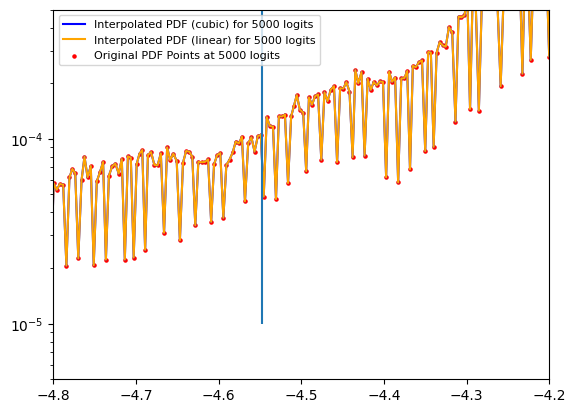

y values   -4.587677
Name: 8557, dtype: float64
probs_np shape: (5000,)
[-104.5006    -30.92478   -27.078815 ...   23.83025    27.632235
   93.33198 ]
borders_np shape: (5001,)
bin_widths shape: (5000,)
[73.57582    3.8459644  1.6027699 ...  2.1105957  3.8019848 65.699745 ]
pdf_values shape: (5000,)
midpoints shape: (5000,)


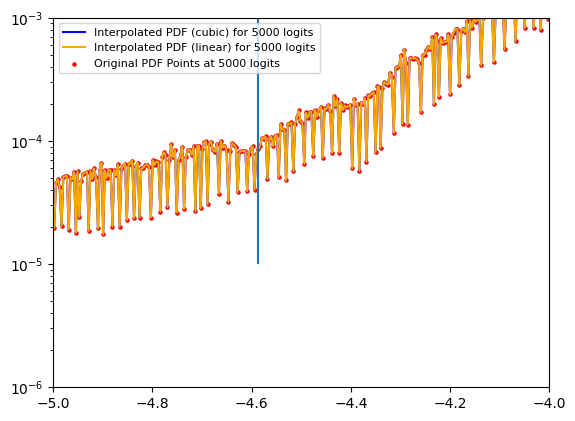

In [20]:
if mode == "load":

    x_lim = (-4.8, -4.2)  # Example x limits
    y_scale = 'log'  # Use 'linear' or 'log' for y-axis scale
    if y_scale == 'log':
        y_lim = (1e-6, 5e4)  # Example y limits
        y_lim = (5e-6, 5e-4)  # Example y limits
    else:
        y_lim = (0, 1)  # Example y limits

    # Define the row index (500th row)
    row_index = 0
    y_value = problematic_cases_q2.iloc[row_index][["y values"]]
    print(y_value)

    # Prepare the figure and axis for plotting
    fig, ax = plt.subplots()

    plot_pdf_from_logits(ax, problematic_logits_q2_torch, borders_q2, x_lim, y_lim, y_scale, id=row_index)

    plt.vlines(y_value, 1e-5, 1)
    plt.show()

    x_lim = (-5, -4)  # Example x limits
    y_scale = 'log'  # Use 'linear' or 'log' for y-axis scale
    if y_scale == 'log':
        y_lim = (1e-6, 1e-3)  # Example y limits
    else:
        y_lim = (0, 1)  # Example y limits
    

    # Define the row index (500th row)
    row_index = 1
    y_value = problematic_cases_q2.iloc[row_index][["y values"]]
    print(y_value)

    # Prepare the figure and axis for plotting
    fig, ax = plt.subplots()

    plot_pdf_from_logits(ax, problematic_logits_q2_torch, borders_q2.squeeze().T, x_lim, y_lim, y_scale, id=row_index)

    plt.vlines(y_value, 1e-5, 1)
    plt.show()

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000,y_bin
0,0.286544,0.315913,0.196862,0.207918,-0.478470,-0.733121,0.405837,-0.590741,-0.563193,-0.539165,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.456878,"(-1, -0.5)"
1,0.358878,0.359571,0.281637,0.272509,1.303051,1.484064,3.074877,0.674396,0.313154,-0.518601,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451,"(-1, -0.5)"
2,0.270917,0.305586,0.186540,0.185323,-0.777790,-1.056299,0.276867,-1.087519,-0.866392,-0.555433,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.496099,"(-1, -0.5)"
3,0.260234,0.297001,0.166072,0.186024,0.213276,-0.058962,0.142388,-0.649525,-0.515941,-0.509552,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451,"(-1, -0.5)"
4,0.301981,0.336770,0.214784,0.217724,-0.729570,-1.058976,0.549073,-0.867136,-0.754282,-0.552363,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.881761,"(-1, -0.5)"
5,0.223882,0.265751,0.132330,0.141330,0.731221,0.136725,-0.088151,-0.622406,-0.534888,-0.503500,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.075916,"(-1, -0.5)"
6,0.166140,0.209757,0.096188,0.080102,-1.227578,-1.381008,-0.286614,-1.431581,-1.351176,-0.521668,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.824602,"(-1, -0.5)"
7,0.278978,0.279664,0.183728,0.199361,0.749946,0.638024,0.496942,0.679523,0.739595,-0.500875,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.051413,"(-1, -0.5)"
8,0.284748,0.316293,0.203226,0.206219,-0.059620,-0.432480,0.434142,-0.479305,-0.556253,-0.594101,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.051413,"(-1, -0.5)"
9,0.469248,0.456612,0.457404,0.431992,5.283155,0.305734,27.667245,1.447781,1.415415,-0.660054,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.419137,"(-1, -0.5)"


C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


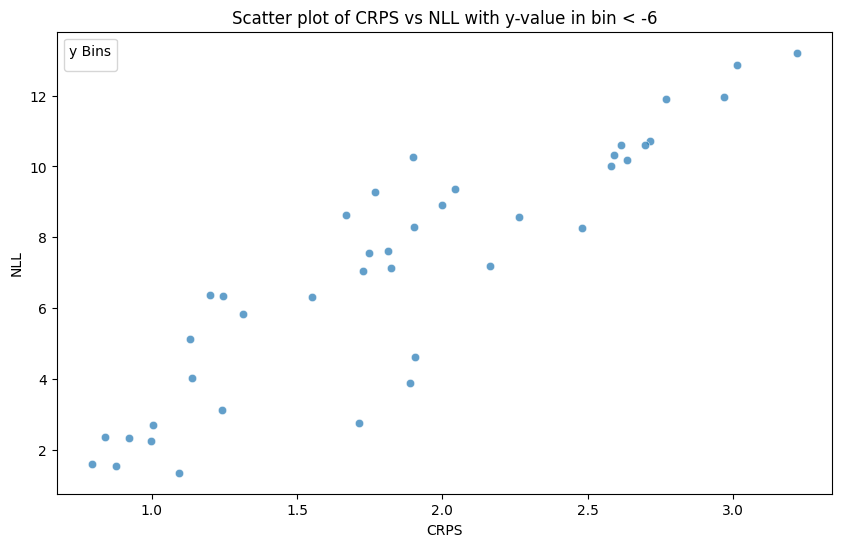

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


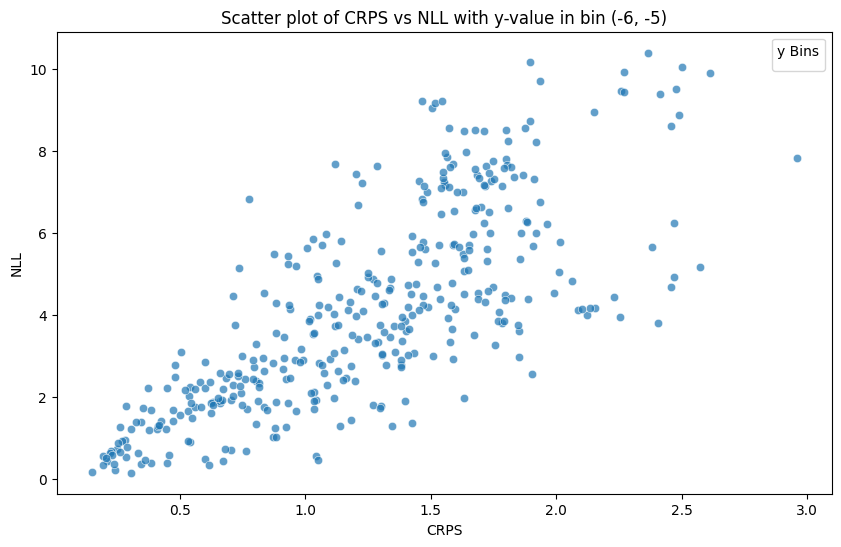

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


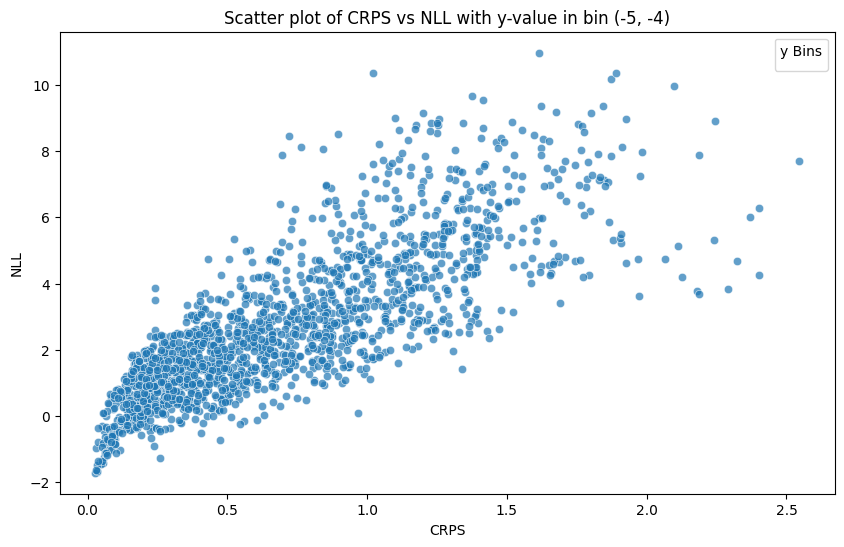

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


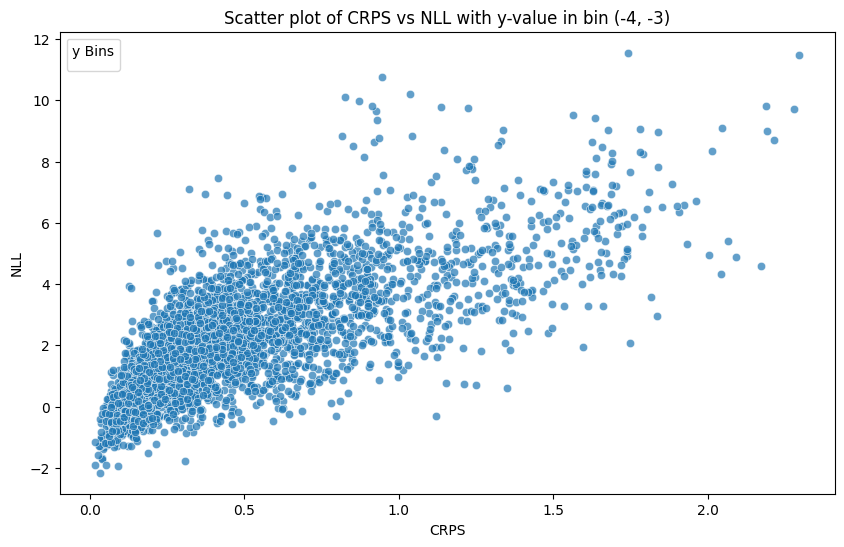

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


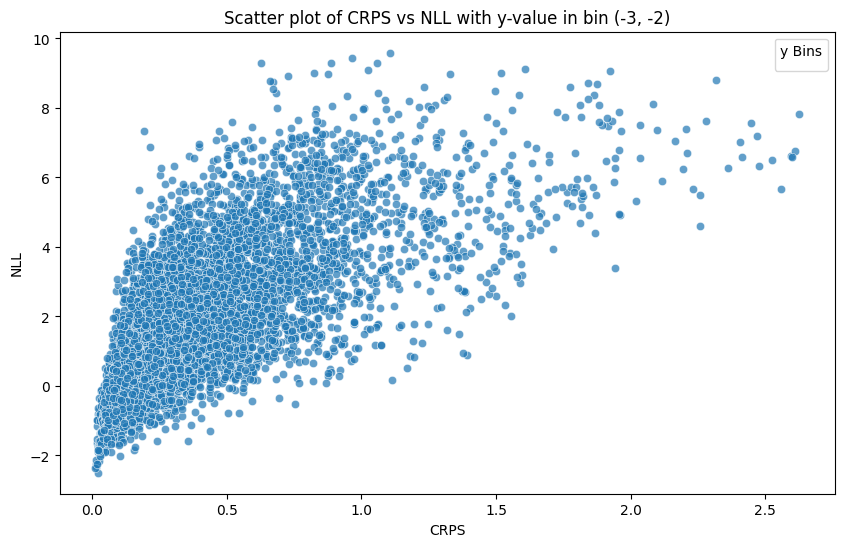

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


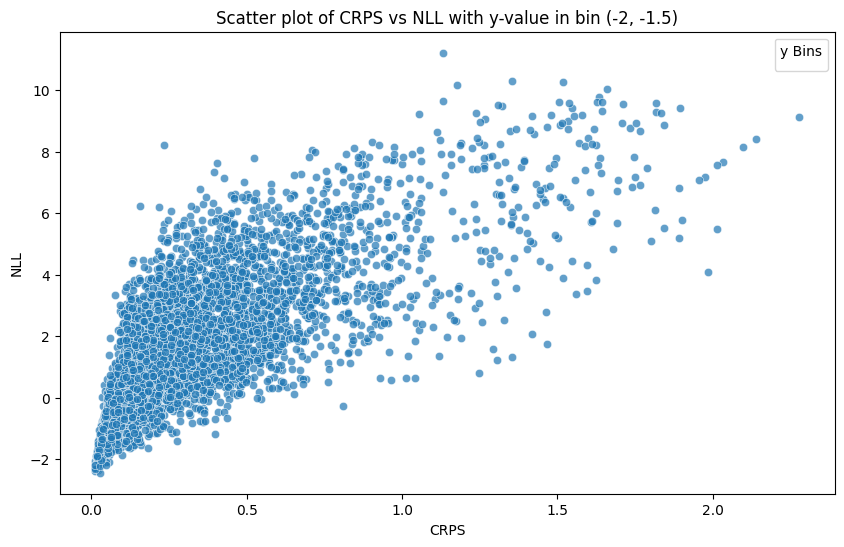

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


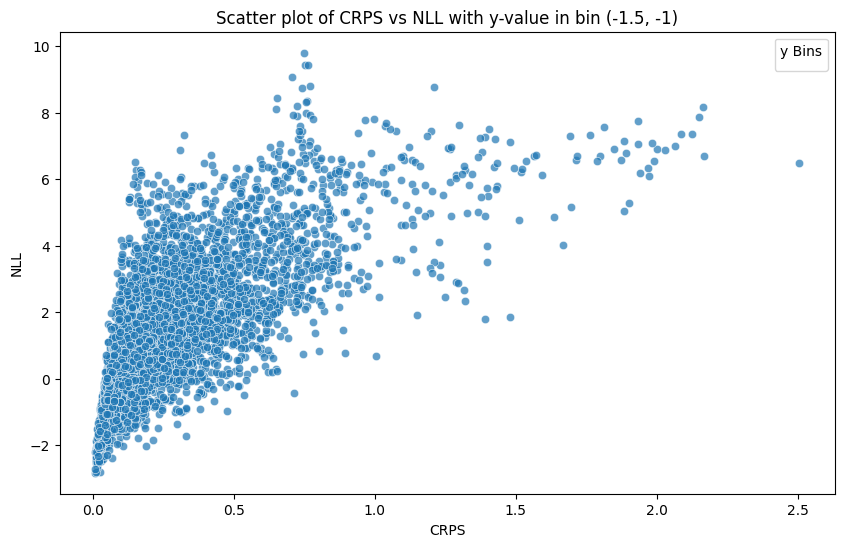

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


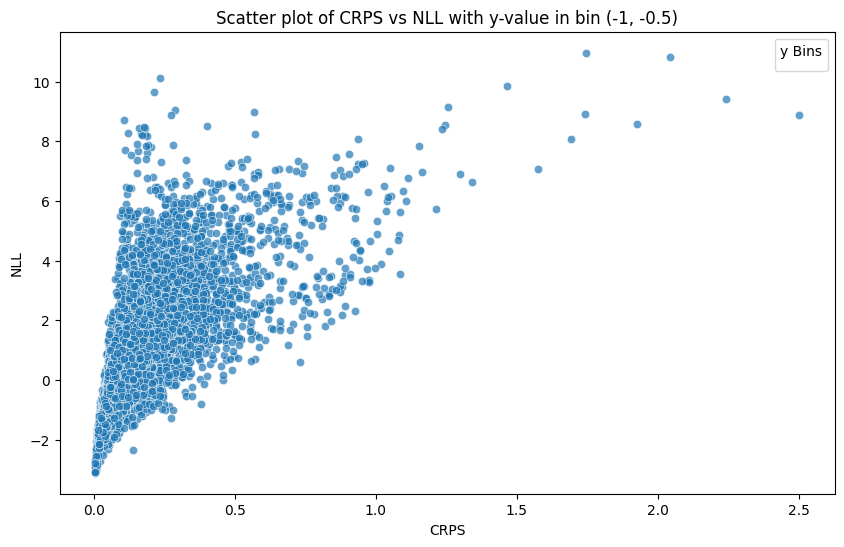

C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)
C:\Users\Minu\AppData\Local\Temp\ipykernel_9420\3252068157.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="y Bins")


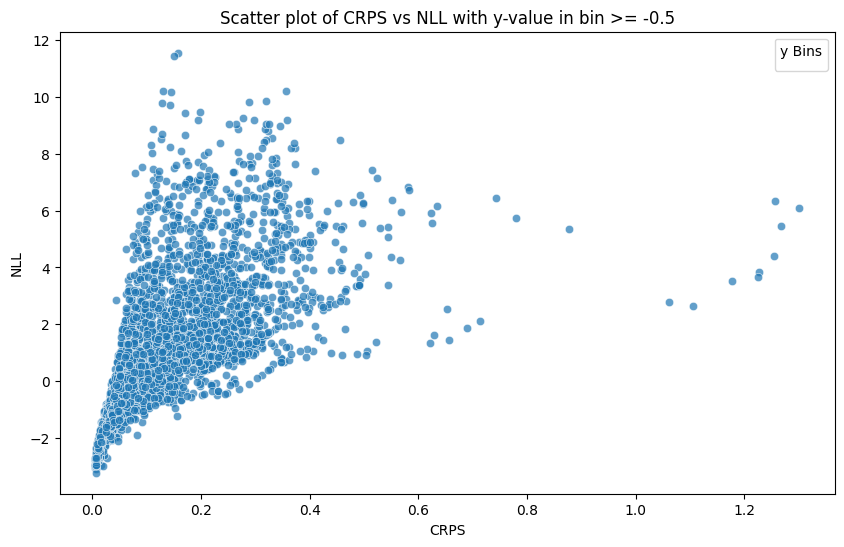

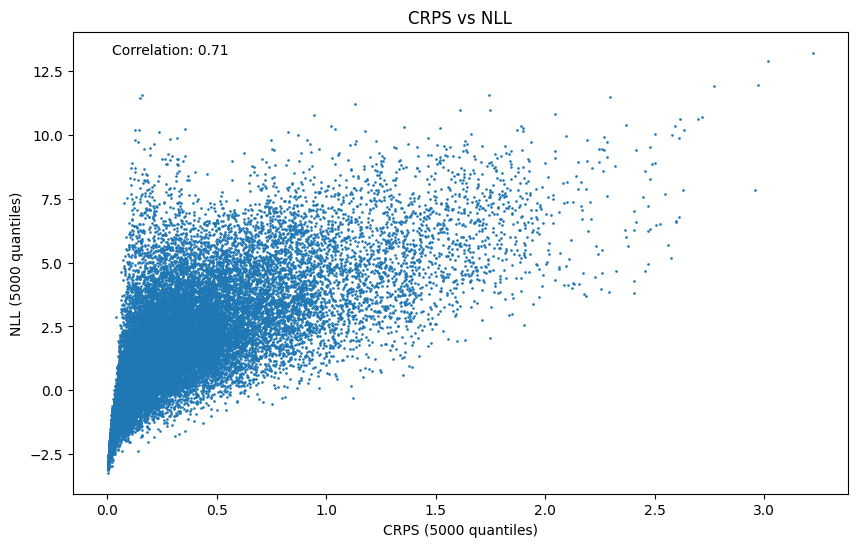

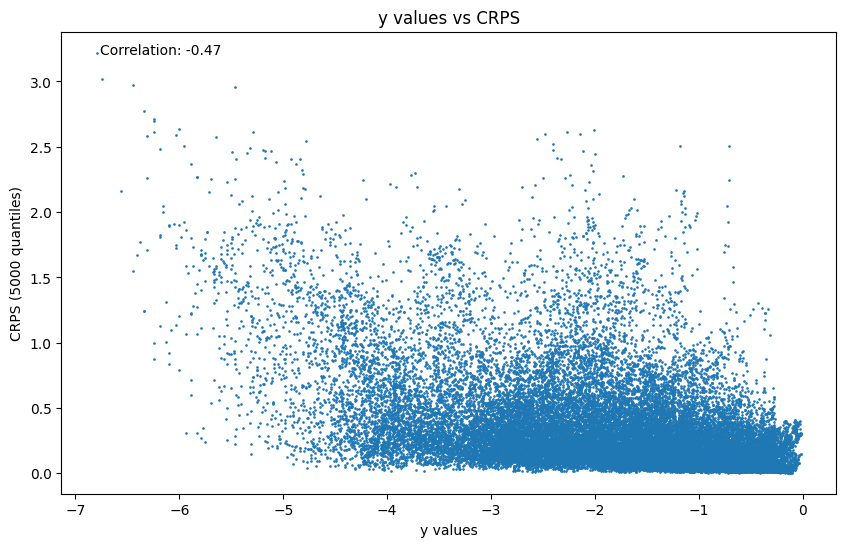

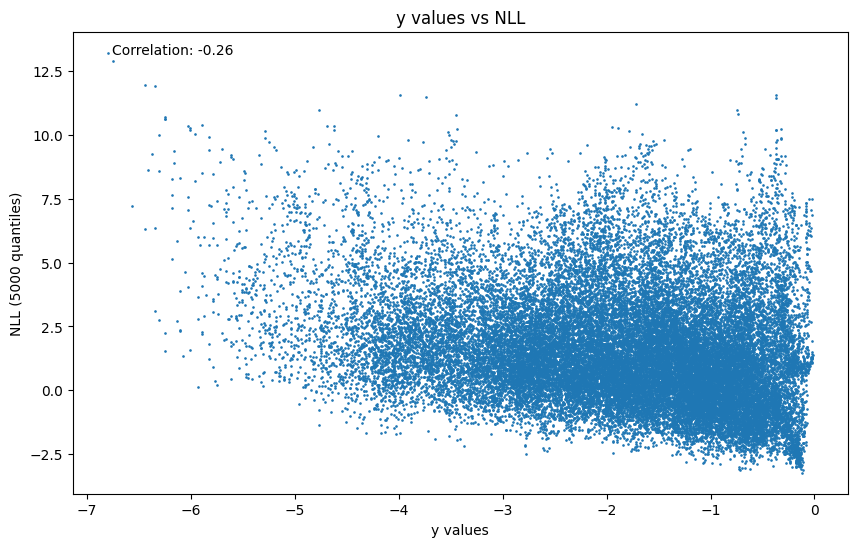

In [21]:
if mode == "load":

    results = pd.concat([first_q["results"], second_q["results"], third_q["results"], fourth_q["results"]], axis=0, ignore_index=True)

    bin_edges = [-10, -6, -5, -4, -3, -2, -1.5, -1, -0.5, 0]  # You can adjust the bins if necessary
    bin_labels = [
        "< -6", "(-6, -5)", "(-5, -4)", "(-4, -3)", 
        "(-3, -2)", "(-2, -1.5)", "(-1.5, -1)", "(-1, -0.5)", ">= -0.5"
    ]

    results["y_bin"] = pd.cut(results["y values"], bins=bin_edges, labels=bin_labels, include_lowest=True)

    display(results.head(10))

    for i in range(0, len(bin_labels)):

        bin = bin_labels[i]
        results_bin = results[results["y_bin"] == bin]

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=results_bin["CRPS (5000 quantiles)"], y=results_bin["NLL (5000 quantiles)"], palette="viridis", alpha=0.7)

        # Labels and title
        plt.xlabel("CRPS")
        plt.ylabel("NLL")
        plt.title(f"Scatter plot of CRPS vs NLL with y-value in bin {bin}")
        plt.legend(title="y Bins")

        # Show plot
        plt.show()


    plt.figure(figsize=(10, 6))
    plt.scatter(results["CRPS (5000 quantiles)"], results["NLL (5000 quantiles)"], s=0.8)
    plt.xlabel("CRPS (5000 quantiles)")
    plt.ylabel("NLL (5000 quantiles)")
    correlation = np.corrcoef(results["CRPS (5000 quantiles)"], results["NLL (5000 quantiles)"])[0, 1]
    plt.text(0.05, 0.95, f"Correlation: {correlation:.2f}", transform=plt.gca().transAxes, fontsize=10)
    plt.title("CRPS vs NLL")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(results["y values"], results["CRPS (5000 quantiles)"], s=0.8)
    corr = np.corrcoef(results["y values"], results["CRPS (5000 quantiles)"])[0,1]
    plt.xlabel("y values")
    plt.ylabel("CRPS (5000 quantiles)")
    plt.text(0.05, 0.95, f"Correlation: {corr:.2f}", transform=plt.gca().transAxes, fontsize=10)
    plt.title("y values vs CRPS")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(results["y values"], results["NLL (5000 quantiles)"], s=0.8)
    corr_ = np.corrcoef(results["y values"], results["NLL (5000 quantiles)"])[0,1]
    plt.xlabel("y values")
    plt.ylabel("NLL (5000 quantiles)")
    plt.text(0.05, 0.95, f"Correlation: {corr_:.2f}", transform=plt.gca().transAxes, fontsize=10)
    plt.title("y values vs NLL")

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")


# Methods to smoothe out pdf

1. Moving average of the pdf of neighboring points
2. Reduce the number of logits used
3. Differentiate the cdf to get the pdf with a good epsilon
4. KDE (fit a series of normal distributions to the data)

case 1


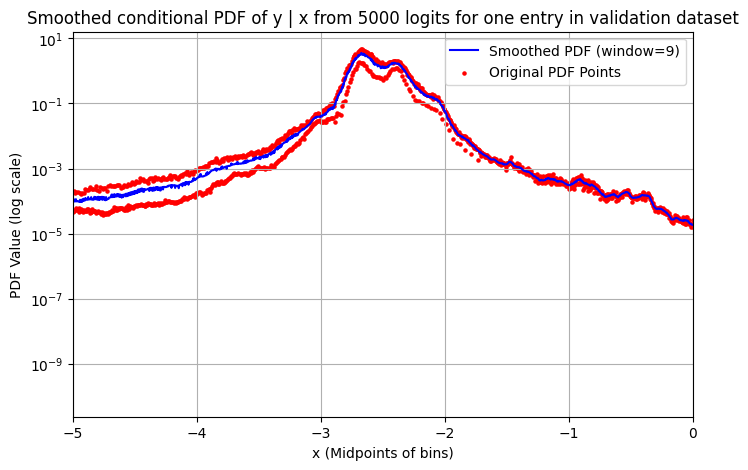

---------------------
zooming into peak (-3 to -2)


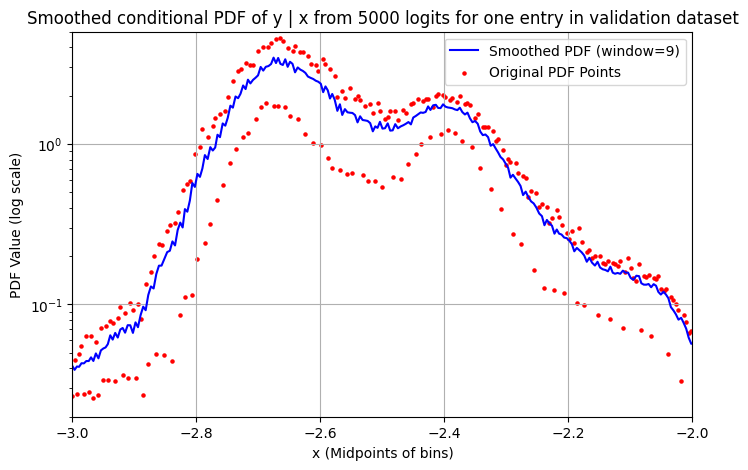

---------------------
zooming into the left side (-4.5 to -3.5)


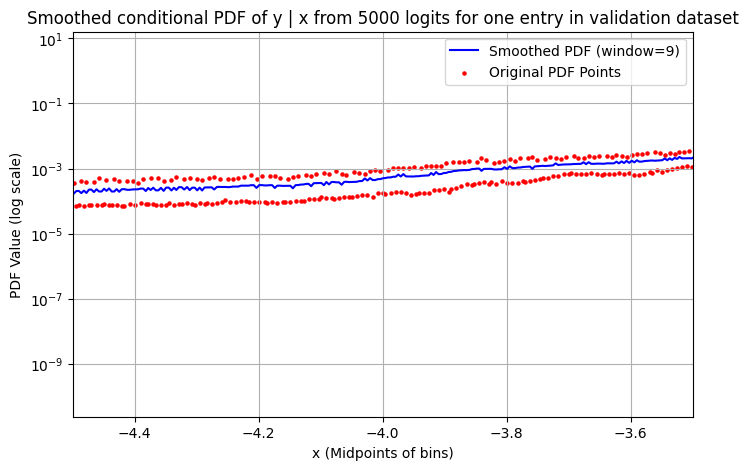

In [22]:
if mode == "load":
    print("case 1")
    plot_pdf_smoothed_with_moving_average(logits=problematic_logits_q1, borders=borders_q1, window_size=9, id=0, case=1, y_scale="log")
    print("---------------------")
    plot_pdf_smoothed_with_moving_average(logits=problematic_logits_q1, borders=borders_q1, window_size=9, id=0, case=2, y_scale="log")
    print("---------------------")
    plot_pdf_smoothed_with_moving_average(logits=problematic_logits_q1, borders=borders_q1, window_size=9, id=0, case=3, y_scale="log")
else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

case 1


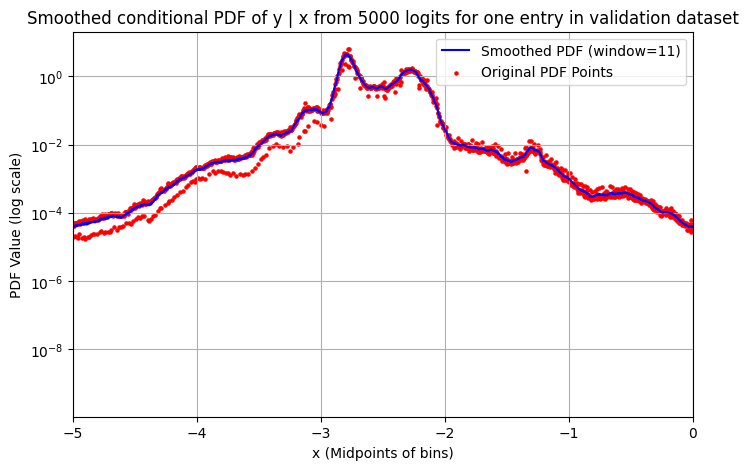

---------------------
zooming into peak (-3 to -2)


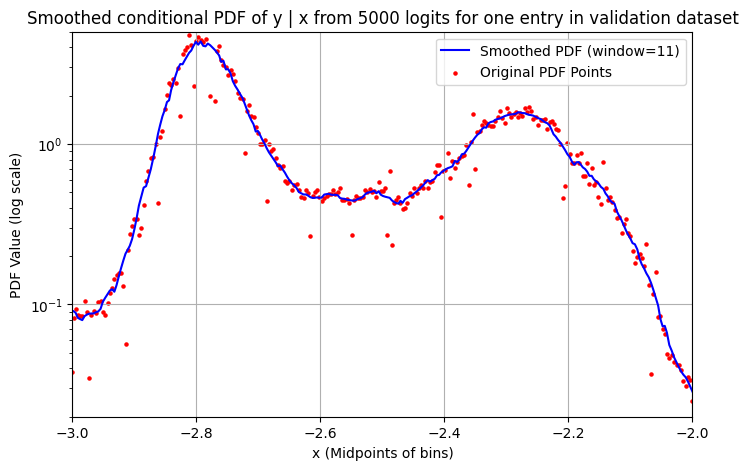

---------------------
zooming into the left side (-4.5 to -3.5)


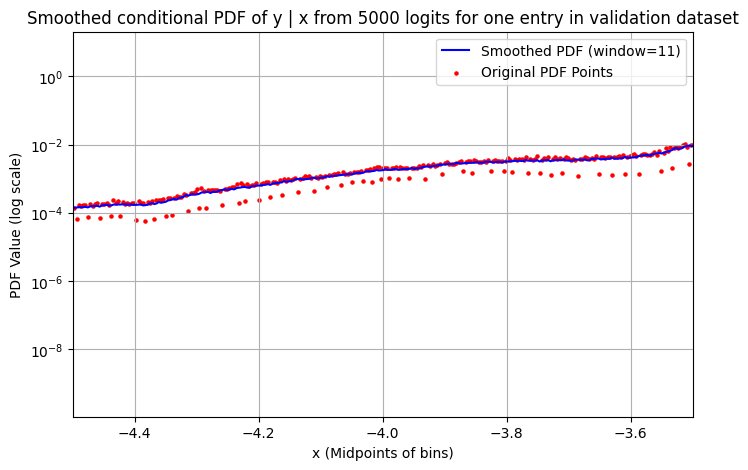

In [23]:
if mode == "load":
    print("case 1")
    plot_pdf_smoothed_with_moving_average(logits=problematic_logits_q2, borders=borders_q2, window_size=11, id=1, case=1, y_scale="log")
    print("---------------------")
    plot_pdf_smoothed_with_moving_average(logits=problematic_logits_q2, borders=borders_q2, window_size=11, id=1, case=2, y_scale="log")
    print("---------------------")
    plot_pdf_smoothed_with_moving_average(logits=problematic_logits_q2, borders=borders_q2, window_size=11, id=1, case=3, y_scale="log")

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

In [24]:
if mode == "load":
    borders_q1_torch = torch.from_numpy(borders_q1)
    borders_q1_torch_sqz = borders_q1_torch.squeeze()

    logits_q1_torch = torch.from_numpy(first_q["results"].iloc[:, 10:].values)

    y_values_q1_torch = torch.from_numpy(first_q["results"]["y values"].values)

    nlls = compute_nll_smoothed(logits_q1_torch, borders_q1_torch_sqz, y_values_q1_torch)

    print(f"total mean: {np.mean(nlls)}")

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

NameError: name 'compute_nll_smoothed' is not defined

# Temp

## created by loading in the results of quarters not directly from TabPFN

## created ny copying the info over from a previous TabPFN result stored in excel

# Test to see if the old results are the same as the new results
- conclusion: all crps, nll, logits calculations are the same across quarters, same for summary_stats (across quarters), meta_info_old

In [ ]:
if mode == "load":
        old_file = "../../TabPFN/ws_10m_ws_100m_pt_96_first_q"
        old_file2 = "../../TabPFN/ws_10m_ws_100m_pt_96_second_q"
        old_file3 = "../../TabPFN/ws_10m_ws_100m_pt_96_third_q"
        old_file4 = "../../TabPFN/ws_10m_ws_100m_pt_96_fourth_q"
        old_file5 = "../../TabPFN/ws_10m_ws_100m_pt_96_summary_stats"
        old_file6 = "../../TabPFN/ws_10m_ws_100m_pt_96_meta_info"

        with open(old_file, "rb") as file:
            first_q_old = pickle.load(file)

        with open(old_file2, "rb") as file:
            second_q_old = pickle.load(file)

        with open(old_file3, "rb") as file:
            third_q_old = pickle.load(file)

        with open(old_file4, "rb") as file:
            fourth_q_old = pickle.load(file)

        with open(old_file5, "rb") as file:
            summary_stats_old = pickle.load(file)

        with open(old_file6, "rb") as file:
            meta_info_old = pickle.load(file)
else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

In [ ]:
if mode == "load":

    summary_dummy = summary_stats_overall.copy()
    summary_dummy = summary_dummy.drop(columns=['NLL smoothed (moving average)'])
    summary_dummy.equals(summary_stats_old)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

In [ ]:
if mode == "load":
    dummy = first_q["results"].copy()
    dummy = dummy.drop(columns=['NLL smoothed (moving average)'])

    df_diff = dummy.equals(first_q_old["results"])
    print(df_diff)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

True


In [ ]:
if mode == "load":
    dummy2 = second_q["results"].copy()
    dummy2 = dummy2.drop(columns=['NLL smoothed (moving average)'])

    df_diff2 = dummy2.equals(second_q_old["results"])
    print(df_diff2)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

True


In [ ]:
if mode == "load":
    dummy3 = third_q["results"].copy()
    dummy3 = dummy3.drop(columns=['NLL smoothed (moving average)'])

    df_diff3 = dummy3.equals(third_q_old["results"])
    print(df_diff3)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

True


In [ ]:
if mode == "load":
    dummy4 = fourth_q["results"].copy()
    dummy4 = dummy4.drop(columns=['NLL smoothed (moving average)'])

    df_diff4 = dummy4.equals(fourth_q_old["results"])
    print(df_diff4)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

True


In [ ]:
if mode == "load":
    meta_info.equals(meta_info_old)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

# Comparison of nll original that came from TabPFN and my smoothed version with taking the average pdf with a windo size of 5
- The smoothed nlls and the original nlls from TabPFN do not seem to be too different when calculating the average with a window size of 5 

In [ ]:
if mode == "load":

    first_q_nll_comparison = pd.concat([
        first_q["results"]["NLL smoothed (moving average)"], 
        first_q_old["results"]["NLL (5000 quantiles)"]
    ], axis=1)

    first_q_nll_comparison.describe()

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

In [ ]:
if mode == "load":

    second_q_nll_comparison = pd.concat([
        second_q["results"]["NLL smoothed (moving average)"], 
        second_q_old["results"]["NLL (5000 quantiles)"]
    ], axis=1)

    second_q_nll_comparison.describe()

else:

    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

In [ ]:
if mode == "load":
    third_q_nll_comparison = pd.concat([
        third_q["results"]["NLL smoothed (moving average)"], 
        third_q_old["results"]["NLL (5000 quantiles)"]
    ], axis=1)

    third_q_nll_comparison.describe()

else:

    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

In [ ]:
if mode == "load":
    fourth_q_nll_comparison = pd.concat([
        fourth_q["results"]["NLL smoothed (moving average)"], 
        fourth_q_old["results"]["NLL (5000 quantiles)"]
    ], axis=1)

    fourth_q_nll_comparison.describe()

else:

    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")

# Testing the impact with smoothed nll with a bigger window size

In [ ]:
if mode == "load":
    
    borders_q1 = first_q['borders'].values
    borders_q2 = second_q['borders'].values
    borders_q3 = third_q['borders'].values
    borders_q4 = fourth_q['borders'].values

    borders_q1_torch = torch.from_numpy(borders_q1)
    borders_q2_torch = torch.from_numpy(borders_q2)
    borders_q3_torch = torch.from_numpy(borders_q3)
    borders_q4_torch = torch.from_numpy(borders_q4)

    borders_q1_torch_sqz = borders_q1_torch.squeeze()
    borders_q2_torch_sqz = borders_q2_torch.squeeze()
    borders_q3_torch_sqz = borders_q3_torch.squeeze()
    borders_q4_torch_sqz = borders_q4_torch.squeeze()

    logits_q1 = first_q["results"].iloc[:, 10:].values
    logits_q2 = second_q["results"].iloc[:, 10:].values
    logits_q3 = third_q["results"].iloc[:, 10:].values
    logits_q4 = fourth_q["results"].iloc[:, 10:].values

    logits_q1_torch = torch.from_numpy(logits_q1)
    logits_q2_torch = torch.from_numpy(logits_q2)
    logits_q3_torch = torch.from_numpy(logits_q3)
    logits_q4_torch = torch.from_numpy(logits_q4)

    y_validation_q1 = first_q["results"]["y values"].values
    y_validation_q2 = second_q["results"]["y values"].values
    y_validation_q3 = third_q["results"]["y values"].values
    y_validation_q4 = fourth_q["results"]["y values"].values

    y_validation_q1_torch = torch.from_numpy(y_validation_q1)
    y_validation_q2_torch = torch.from_numpy(y_validation_q2)
    y_validation_q3_torch = torch.from_numpy(y_validation_q3)
    y_validation_q4_torch = torch.from_numpy(y_validation_q4)

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

In [32]:
if mode == "load":
        plot_pdf_smoothed_with_moving_average(logits=logits_q1, borders=borders_q1, window_size=100, id=50, case=1, y_scale="log")
else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: train, but current mode is: {mode}")
    


NameError: name 'logits_q1' is not defined

<Figure size 800x500 with 0 Axes>

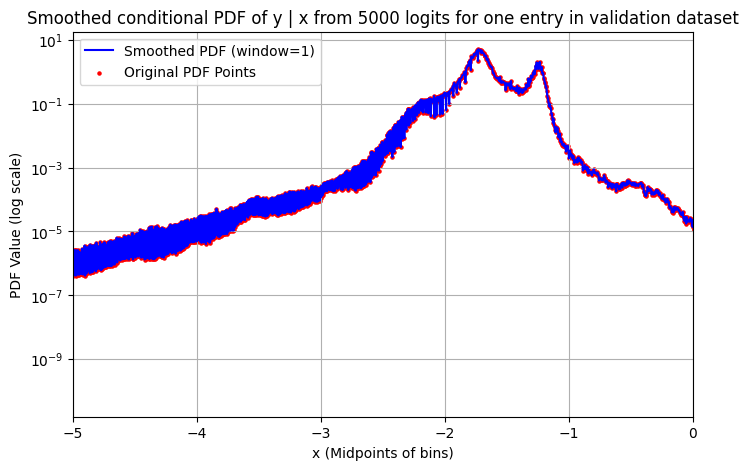

zooming into peak (-3 to -2)


<Figure size 800x500 with 0 Axes>

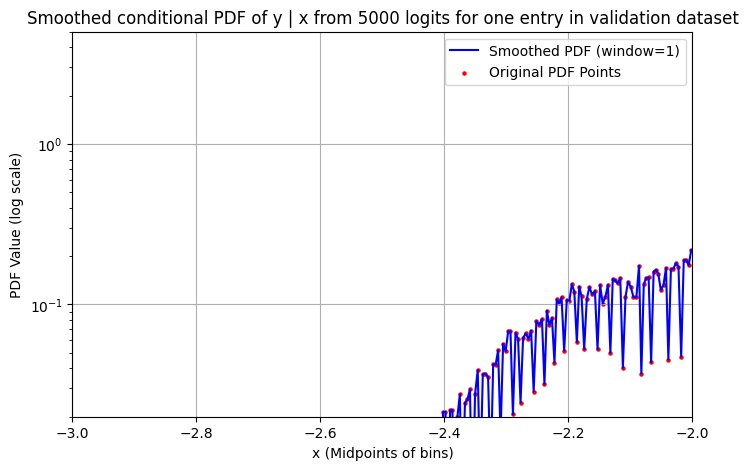

zooming into the left side (-4.5 to -3.5)


<Figure size 800x500 with 0 Axes>

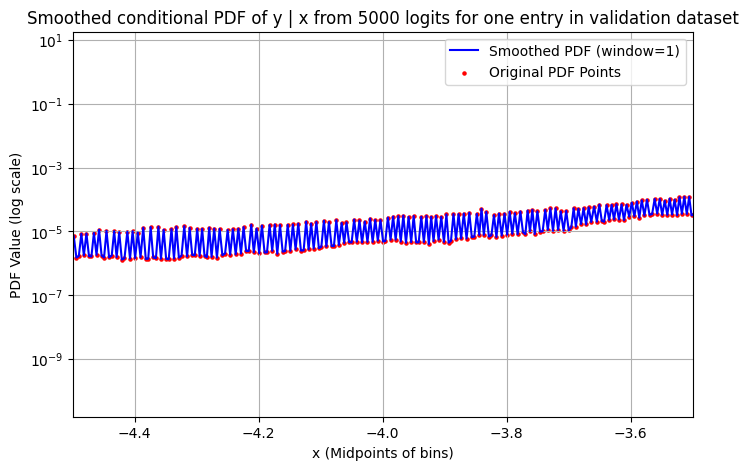

<Figure size 800x500 with 0 Axes>

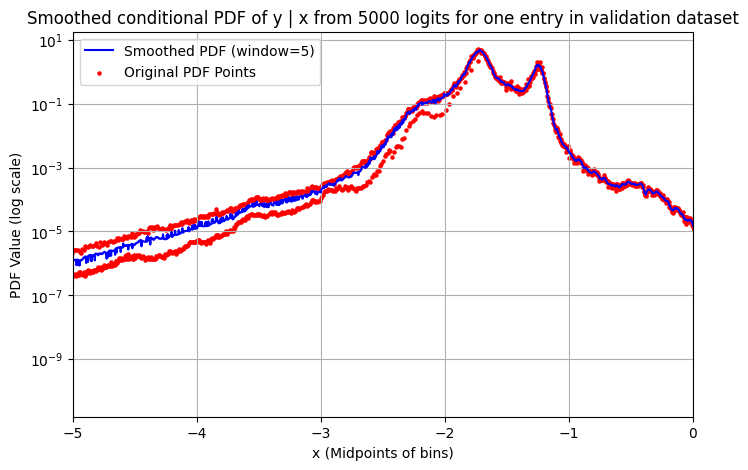

zooming into peak (-3 to -2)


<Figure size 800x500 with 0 Axes>

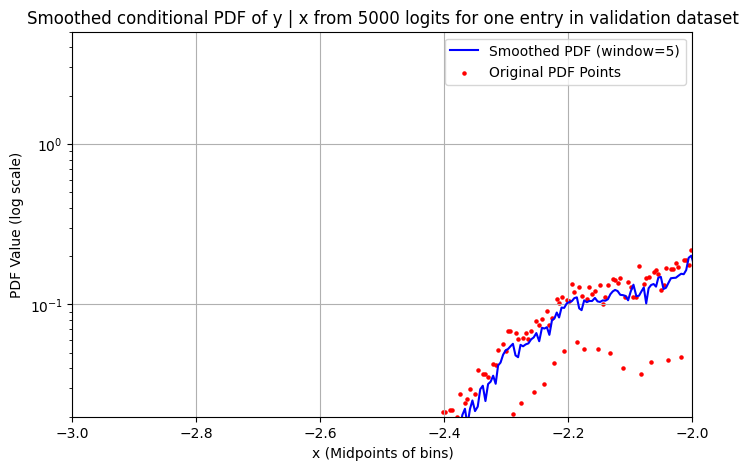

zooming into the left side (-4.5 to -3.5)


<Figure size 800x500 with 0 Axes>

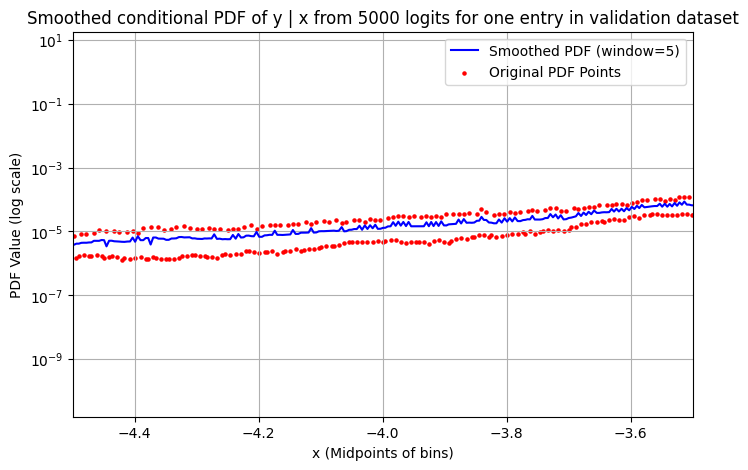

<Figure size 800x500 with 0 Axes>

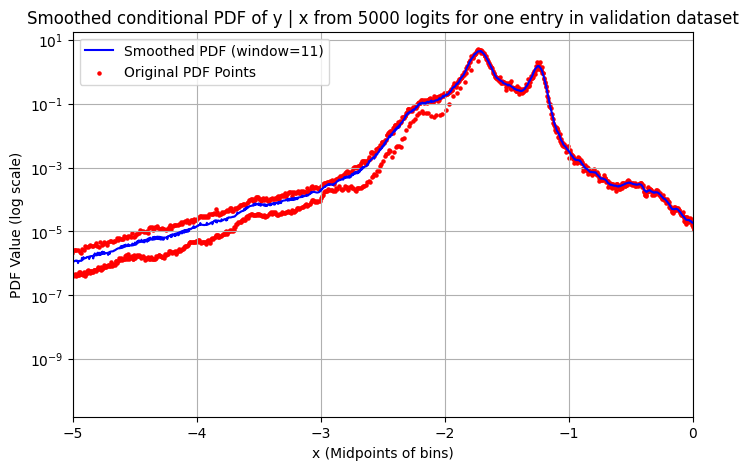

zooming into peak (-3 to -2)


<Figure size 800x500 with 0 Axes>

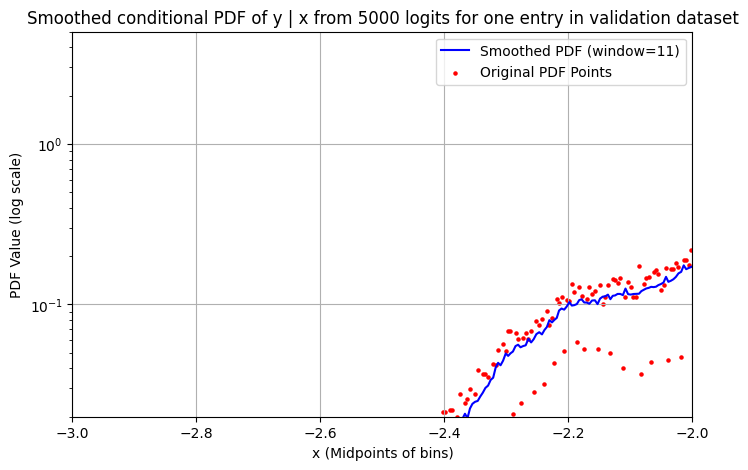

zooming into the left side (-4.5 to -3.5)


<Figure size 800x500 with 0 Axes>

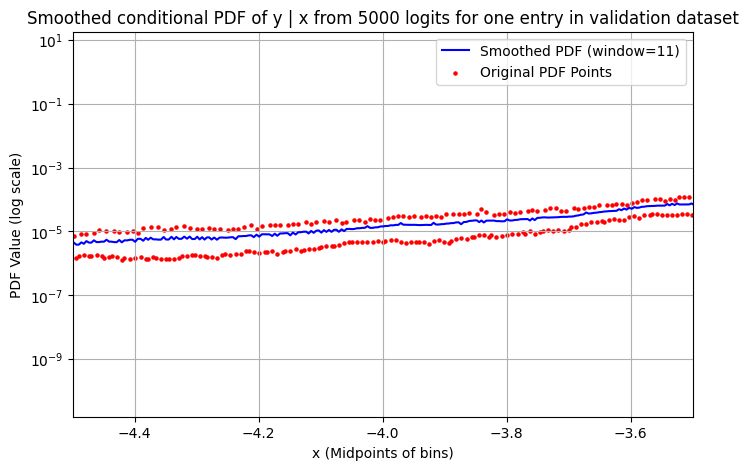

<Figure size 800x500 with 0 Axes>

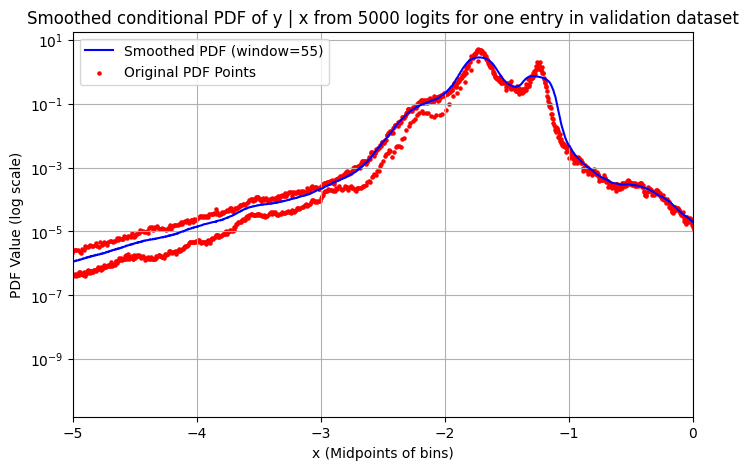

zooming into peak (-3 to -2)


<Figure size 800x500 with 0 Axes>

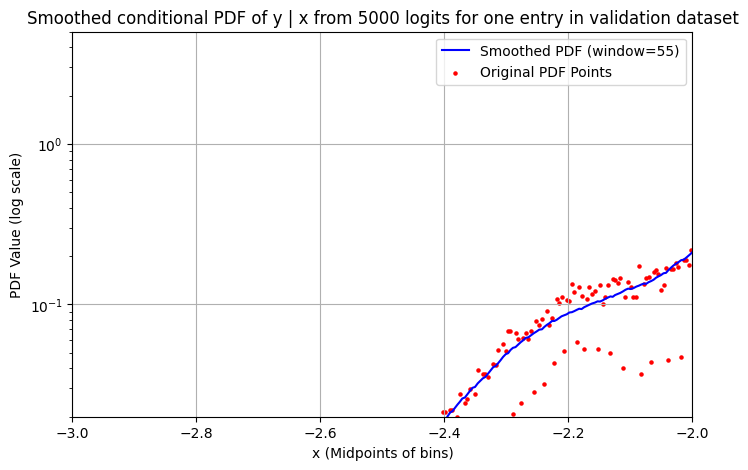

zooming into the left side (-4.5 to -3.5)


<Figure size 800x500 with 0 Axes>

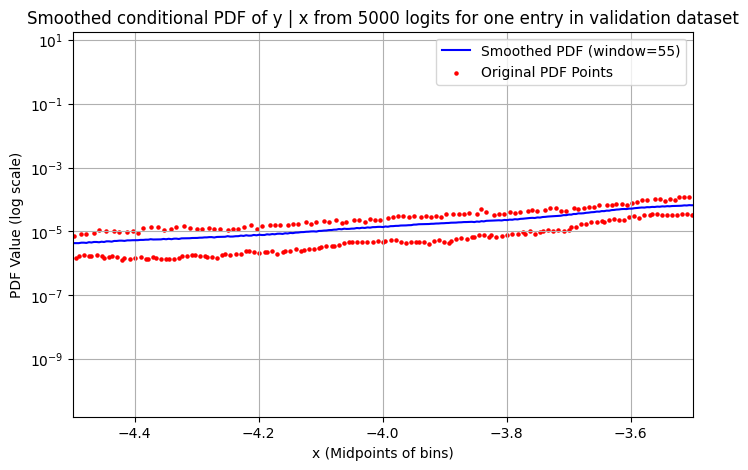

<Figure size 800x500 with 0 Axes>

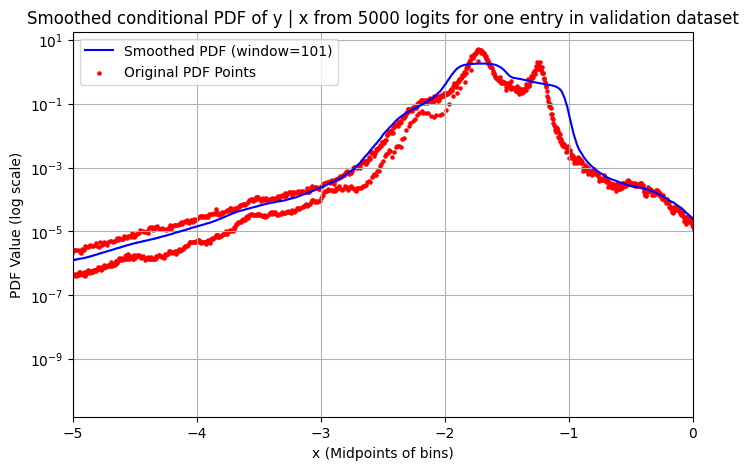

zooming into peak (-3 to -2)


<Figure size 800x500 with 0 Axes>

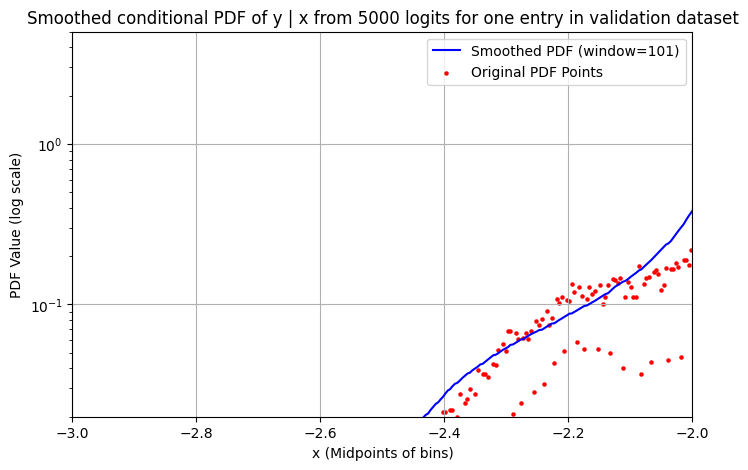

zooming into the left side (-4.5 to -3.5)


<Figure size 800x500 with 0 Axes>

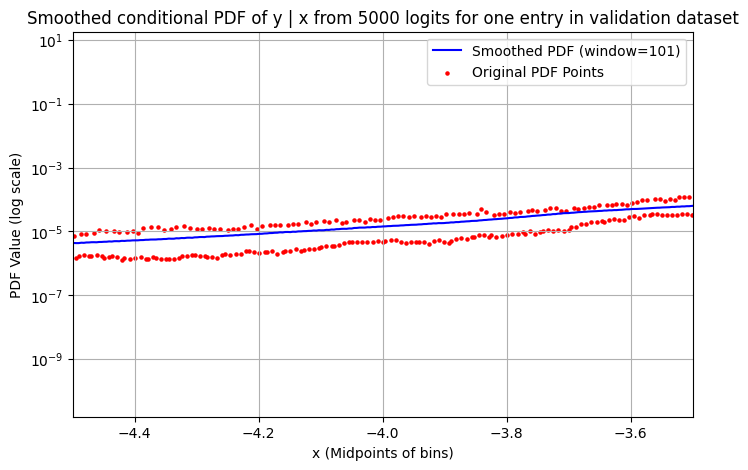

In [ ]:
if mode == "load":

        window_sizes = [1, 5, 11, 55, 101]  # List of window sizes to test
        
        for window_size in window_sizes:
                plt.figure(figsize=(8,5))
                plot_pdf_smoothed_with_moving_average(logits=logits_q1, borders=borders_q1, window_size=window_size, id=100, case=1, y_scale="log")
                plt.close()

                plt.figure(figsize=(8,5))
                plot_pdf_smoothed_with_moving_average(logits=logits_q1, borders=borders_q1, window_size=window_size, id=100, case=2, y_scale="log")
                plt.close()

                plt.figure(figsize=(8,5))
                plot_pdf_smoothed_with_moving_average(logits=logits_q1, borders=borders_q1, window_size=window_size, id=100, case=3, y_scale="log")
                plt.close()

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

In [ ]:
if mode == "load":

    for window_size in window_sizes:
        print(f"Processing with window size: {window_size}")

        nlls_q1 = compute_nll_smoothed(logits=logits_q1_torch, borders=borders_q1_torch.squeeze(), y_values=y_validation_q1_torch, window_size=window_size)
        nll_mean_q1 = np.mean(nlls_q1)

        nlls_q2 = compute_nll_smoothed(logits=logits_q2_torch, borders=borders_q2_torch.squeeze(), y_values=y_validation_q2_torch, window_size=window_size)
        nll_mean_q2 = np.mean(nlls_q2)

        nlls_q3 = compute_nll_smoothed(logits=logits_q3_torch, borders=borders_q3_torch.squeeze(), y_values=y_validation_q3_torch, window_size=window_size)
        nll_mean_q3 = np.mean(nlls_q3)

        nlls_q4 = compute_nll_smoothed(logits=logits_q4_torch, borders=borders_q4_torch.squeeze(), y_values=y_validation_q4_torch, window_size=window_size)
        nll_mean_q4 = np.mean(nlls_q4)

        nll_mean_overall = np.mean(np.concatenate([nlls_q1, nlls_q2, nlls_q3, nlls_q4]))
        nll_median_overall = np.median(np.concatenate([nlls_q1, nlls_q2, nlls_q3, nlls_q4]))
        nll_min_overall = np.min(np.concatenate([nlls_q1, nlls_q2, nlls_q3, nlls_q4]))
        nll_max_overall = np.max(np.concatenate([nlls_q1, nlls_q2, nlls_q3, nlls_q4]))

        # Overall NLL statistics
        print(f"Window Size: {window_size}")
        print(f"Overall NLL Mean: {nll_mean_overall:.4f}")
        print(f"Overall NLL Min: {nll_min_overall:.4f}")
        print(f"Overall NLL Median: {nll_median_overall:.4f}")
        print(f"Overall NLL Max: {nll_max_overall:.4f}")

        print("-" * 50)  # Separator for better readability between window sizes


else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

Processing with window size: 1
Window Size: 1
Overall NLL Mean: 1.5378
Overall NLL Min: -3.2220
Overall NLL Median: 1.1783
Overall NLL Max: 23.0259
--------------------------------------------------
Processing with window size: 5
Window Size: 5
Overall NLL Mean: 1.4967
Overall NLL Min: -3.1195
Overall NLL Median: 1.1457
Overall NLL Max: 13.1787
--------------------------------------------------
Processing with window size: 11
Window Size: 11
Overall NLL Mean: 1.4819
Overall NLL Min: -2.9307
Overall NLL Median: 1.1266
Overall NLL Max: 13.2002
--------------------------------------------------
Processing with window size: 55
Window Size: 55
Overall NLL Mean: 1.2814
Overall NLL Min: -1.7002
Overall NLL Median: 0.8569
Overall NLL Max: 11.0176
--------------------------------------------------
Processing with window size: 101
Window Size: 101
Overall NLL Mean: 1.1001
Overall NLL Min: -1.1118
Overall NLL Median: 0.5792
Overall NLL Max: 10.6948
------------------------------------------------

# Observation

the summary of the individual quarters is being saved in the files (7-9) but the information is already stored in the files (1-4) meaning the summary statistics within a quarter is saved twice
- filepath7 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_first_q"
- filepath8 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_second_q"
- filepath9 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_third_q"
- filepath10 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_summary_stats_fourth_q"

- filepath1 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_first_q"
- filepath2 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_second_q"
- filepath3 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_third_q"
- filepath4 = "../../TabPFN/tests/ws_10m_ws_100m_pt_96_fourth_q"

In [ ]:
if mode == "load":
        with open(filepath7, "rb") as file:
            summary_first_q = pickle.load(file)

        with open(filepath8, "rb") as file:
            summary_second_q = pickle.load(file)

        with open(filepath9, "rb") as file:
            summary_third_q = pickle.load(file)

        with open(filepath10, "rb") as file:
            summary_fourth_q = pickle.load(file)

        print(first_q["summary"].equals(summary_first_q))
        print(second_q["summary"].equals(summary_second_q))
        print(third_q["summary"].equals(summary_third_q))
        print(fourth_q["summary"].equals(summary_fourth_q))

else:
    # Do nothing if the mode doesn't match
    print(f"Skipping this cell, required mode: load, but current mode is: {mode}")

True
True
True
True


## Creating meta file

In [41]:
first_q["results"]["Decile_1"]

KeyError: 'Decile_1'

In [1]:
import pickle

file_path = "C:/Users/Minu/Documents/TabPFN/ws_10m_ws_100m_pt_96_first_q"

with open(file_path, "rb") as f:
    old = pickle.load(f)


In [6]:
old["results"].head(51)

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.286544,0.315913,0.196862,0.207918,-0.478470,-0.733121,0.405837,-0.590741,-0.539165,-18.409662,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.456878
1,0.358878,0.359571,0.281637,0.272509,1.303051,1.484064,3.074877,0.674396,-0.518601,-19.012306,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451
2,0.270917,0.305586,0.186540,0.185323,-0.777790,-1.056299,0.276867,-1.087519,-0.555433,-18.425961,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.496099
3,0.260234,0.297001,0.166072,0.186024,0.213276,-0.058962,0.142388,-0.649525,-0.509552,-18.895119,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451
4,0.301981,0.336770,0.214784,0.217724,-0.729570,-1.058976,0.549073,-0.867136,-0.552363,-19.707369,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.881761
5,0.223882,0.265751,0.132330,0.141330,0.731221,0.136725,-0.088151,-0.622406,-0.503500,-18.901169,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.075916
6,0.166140,0.209757,0.096188,0.080102,-1.227578,-1.381008,-0.286614,-1.431581,-0.521668,-18.267200,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.824602
7,0.278978,0.279664,0.183728,0.199361,0.749946,0.638024,0.496942,0.679523,-0.500875,-16.688583,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.051413
8,0.284748,0.316293,0.203226,0.206219,-0.059620,-0.432480,0.434142,-0.479305,-0.594101,-17.123846,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.051413
9,0.469248,0.456612,0.457404,0.431992,5.283155,0.305734,27.667245,1.447781,-0.660054,-16.588171,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.419137


In [42]:
first_q["results"]


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),NLL smoothed (moving average),y values,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.286544,0.315913,0.196862,0.207918,-0.478470,-0.733121,0.405837,-0.590741,-0.563193,-0.539165,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.456878
1,0.358878,0.359571,0.281637,0.272509,1.303051,1.484064,3.074877,0.674396,0.313154,-0.518601,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451
2,0.270917,0.305586,0.186540,0.185323,-0.777790,-1.056299,0.276867,-1.087519,-0.866392,-0.555433,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.496099
3,0.260234,0.297001,0.166072,0.186024,0.213276,-0.058962,0.142388,-0.649525,-0.515941,-0.509552,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.670451
4,0.301981,0.336770,0.214784,0.217724,-0.729570,-1.058976,0.549073,-0.867136,-0.754282,-0.552363,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.881761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,0.309229,0.241863,0.199558,0.232641,1.105723,0.843659,0.309127,1.076309,1.353467,-1.343460,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.977304
8636,0.336251,0.273383,0.228440,0.259161,1.246462,1.206661,0.579433,1.845053,1.665346,-1.336049,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.864826
8637,0.387213,0.324886,0.320520,0.315100,4.170874,1.167789,1.476415,1.946900,1.924014,-1.332029,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.707641
8638,0.442018,0.417590,0.395403,0.406395,4.196091,3.771199,1.958425,3.097625,2.922836,-1.319186,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.001402


In [31]:
first_q["results"][["CRPS (5000 quantiles)", "NLL (5000 quantiles)"]].head(10)

,CRPS (5000 quantiles),NLL (5000 quantiles)
0,0.207918,-0.590741
1,0.272509,0.674396
2,0.185323,-1.087519
3,0.186024,-0.649525
4,0.217724,-0.867136
5,0.141330,-0.622406
6,0.080102,-1.431581
7,0.199361,0.679523
8,0.206219,-0.479305
9,0.431992,1.447781
